In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-11-04 13:49:45.170182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Load dataset from csv file
dataset = np.loadtxt('dataset.csv', delimiter=',')
print(dataset.shape)

(112, 32)


In [22]:

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=(32,))
    x = layers.Dense(16, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    return models.Model(inputs, [z_mean, z_log_var, z], name='encoder')

def build_decoder(output_shape, latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8, activation='relu')(latent_inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(output_shape, activation='sigmoid')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

# Load dataset from CSV file
def load_dataset(csv_path):
    data = pd.read_csv(csv_path)
    return data.values

# Prepare and scale the dataset
def prepare_dataset(data):
    # Normalize the data to range [0, 1]
    data = data.astype('float32') / np.max(data)
    return data

input_shape = 32
latent_dim = 4
csv_path = 'dataset.csv'

# Load and prepare the dataset
data = load_dataset(csv_path)
data = prepare_dataset(data)

# Build the encoder, decoder, and VAE model
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(input_shape, latent_dim)
vae = VAE(encoder, decoder)

vae.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train the VAE model
history = vae.fit(data, data, epochs=40, batch_size=16, validation_split=0.3)

# Summary of the encoder, decoder and VAE
encoder.summary()
decoder.summary()
vae.summary()


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2854 - val_loss: 0.2946
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2556 - val_loss: 0.2631
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2355 - val_loss: 0.2463
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2222 - val_loss: 0.2310
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2092 - val_loss: 0.2243
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2062 - val_loss: 0.2184
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2034 - val_loss: 0.2114
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1963 - val_loss: 0.2088
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1889 - val_loss: 0.2035
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1866 - val_loss: 0.2043
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1849 - val_loss: 0.2015
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1816 - val_loss: 0.1990
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        528 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dropout_4[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        136 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8)         │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 4)         │         36 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 4)         │         36 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 4)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 832 (3.25 KB)

 Trainable params: 784 (3.06 KB)

 Non-trainable params: 48 (192.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824 (3.22 KB)

 Trainable params: 776 (3.03 KB)

 Non-trainable params: 48 (192.00 B)

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 4), (None, 4), │           832 │
│                                 │ (None, 4)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32)             │           824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,778 (18.67 KB)

 Trainable params: 1,560 (6.09 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 3,122 (12.20 KB)

In [23]:

#Sending training data through TRAINED encoder to get vectors to visualise latent space
# latent_vectors = []
# for testing in dataset:
#     test_data = testing

#     test_data = np.reshape(test_data, (1, 32))

#     encoded_data = encoder.predict(test_data)

#     latent_vectors.append(encoded_data[0])


# latent_vectors = np.array(latent_vectors)


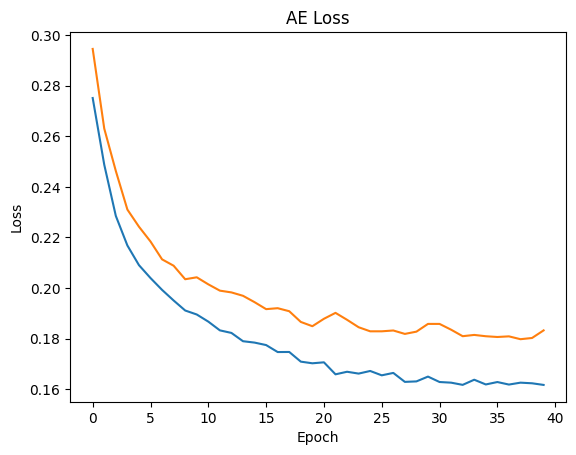

In [24]:
#Plotting loss over epoches

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
# Function to plot latent vectors
# def plot_latent_vectors(latent_vectors):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1])
#     plt.xlabel('Latent D
# imension 1')
#     plt.ylabel('Latent Dimension 2')
#     plt.title('Latent Vectors Visualization (Dim 1 vs Dim 2)')

#     plt.subplot(1, 2, 2)
#     plt.scatter(latent_vectors[:, 2], latent_vectors[:, 3])
#     plt.xlabel('Latent Dimension 3')
#     plt.ylabel('Latent Dimension 4')
#     plt.title('Latent Vectors Visualization (Dim 3 vs Dim 4)')

#     plt.tight_layout()
#     plt.show()
# z_mean, z_log_var, z = encoder.predict(data)    
# plot_latent_vectors(z)



In [6]:
# Function to generate new data using the decoder
def generate_new_data(decoder, latent_dim, num_samples=10):
    generated_data = np.zeros(data.shape)
    # Sample from the standard normal distribution
    for i in range(num_samples):
        z_samples = np.random.normal(size=(1, latent_dim))
        generated_rhythm = decoder.predict(z_samples,verbose=False)
        split = np.split(generated_rhythm[0],2)
        
        steps = split[0]
        
        substeps = split[1]
        
        output1 = []
        tolerance=0.5
        for op in steps:
            if op > tolerance:
                output1.append(1)
            else: output1.append(0)
        
        op = np.array(output1)
        op = np.append(op,substeps)
        generated_data[i,:] = op
    
    return generated_data

In [21]:
generated_r = generate_new_data(decoder,latent_dim, num_samples=1)
print(generated_r[0])

[1.         1.         1.         1.         1.         1.
 0.         1.         1.         1.         0.         1.
 1.         0.         1.         0.         0.39257306 0.33732903
 0.37299198 0.36929917 0.3171404  0.48845938 0.31595689 0.26123318
 0.29390636 0.34300867 0.26503944 0.29251653 0.30964676 0.3257595
 0.28242424 0.29890546]


In [ ]:
# # Generate new data

# for g in range(5):

#     generated_rhythm = generate_new_data(decoder,latent_dim, num_samples=1)
#     #print(generated_rhythm)
    
#     split = np.split(generated_rhythm[0],2)
    
#     steps = split[0]
    
#     substeps = split[1]
    
#     output1 = []
#     output2 = []
#     seq=[]
#     tolerance=0.5
#     for op in steps:
#         if op > tolerance:
#             output1.append(1)
#         else: output1.append(0)
            
#     for s in substeps:
#         op = int(s * (6 - -6) + -6)
#         output2.append(op)
        
#     # print('AE: Raw Generation ',generated_rhythm)
#     print('Step on/off: ',output1)
#     print('48-PPQN substeps ',output2)

In [ ]:
# Function to perform Bayesian Inference
def bayesian_inference(data, prior_mean=0, prior_variance=1, likelihood_variance=0.5):
    # Observed data mean and variance
    observed_mean = np.mean(data)
    observed_variance = np.var(data)
    
    # Posterior mean and variance calculation using Bayesian update
    posterior_variance = 1 / (1 / prior_variance + len(data) / likelihood_variance)
    posterior_mean = posterior_variance * (prior_mean / prior_variance + len(data) * observed_mean / likelihood_variance)
    
    return posterior_mean, posterior_variance

synthetic_data = generate_new_data(decoder,latent_dim, num_samples= data.shape[0])
real_data = data

# Inference with Real Data Only
posterior_mean_real, posterior_variance_real = bayesian_inference(real_data)

# Inference with Synthetic Data Only
posterior_mean_synthetic, posterior_variance_synthetic = bayesian_inference(synthetic_data)

# Inference with Combined Data (Real + Synthetic)
combined_data = np.vstack((real_data, synthetic_data))
posterior_mean_combined, posterior_variance_combined = bayesian_inference(combined_data)

# Display Results
print(f"Posterior Mean with Real Data: {posterior_mean_real}")
print(f"Posterior Variance with Real Data: {posterior_variance_real}\n")

print(f"Posterior Mean with Synthetic Data: {posterior_mean_synthetic}")
print(f"Posterior Variance with Synthetic Data: {posterior_variance_synthetic}\n")

print(f"Posterior Mean with Combined Data: {posterior_mean_combined}")
print(f"Posterior Variance with Combined Data: {posterior_variance_combined}\n")

# Plot the Posterior Distributions for Visual Comparison
x = np.linspace(-1, 1, 200)

# Posterior with Real Data Only
posterior_real = (1 / np.sqrt(2 * np.pi * posterior_variance_real)) * np.exp(-0.5 * (x - posterior_mean_real)**2 / posterior_variance_real)

# Posterior with Synthetic Data Only
posterior_synthetic = (1 / np.sqrt(2 * np.pi * posterior_variance_synthetic)) * np.exp(-0.5 * (x - posterior_mean_synthetic)**2 / posterior_variance_synthetic)

# Posterior with Combined Data
posterior_combined = (1 / np.sqrt(2 * np.pi * posterior_variance_combined)) * np.exp(-0.5 * (x - posterior_mean_combined)**2 / posterior_variance_combined)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, posterior_real, label='Posterior with Real Data', color='blue')
plt.plot(x, posterior_synthetic, label='Posterior with Synthetic Data', color='red')
plt.plot(x, posterior_combined, label='Posterior with Combined Data', color='green')
plt.xlabel("Hypothesis Mean")
plt.ylabel("Posterior Probability Density")
plt.title("Posterior Distributions with Real, Synthetic, and Combined Data")
plt.legend()
plt.show()

In [ ]:
# Inference on Combined Data (Real + Synthetic)
combined_data = np.vstack((real_data, synthetic_data))
posterior_mean, posterior_variance = bayesian_inference(combined_data)

# Enhanced Sampling from Posterior-Informed Latent Space
# Sampling from posterior with learned mean and variance
def posterior_sampling(mean, variance, num_samples=100):
    samples = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_samples, latent_dim))
    return samples

# Generate new synthetic data using posterior-informed sampling
posterior_samples = posterior_sampling(posterior_mean, posterior_variance, num_samples=100)
posterior_synthetic_data = decoder.predict(posterior_samples)

# Display real vs synthetic samples for comparison
def plot_samples(data, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):  # Displaying 5 sample vectors
        plt.plot(data[i], label=f"Sample {i+1}")
    plt.title(title)
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

plot_samples(real_data, "Real Data Samples")
plot_samples(synthetic_data, "VAE Synthetic Data (Standard Sampling)")
plot_samples(posterior_synthetic_data, "VAE Synthetic Data (Posterior-Informed Sampling)")

# Comparing the sample means and variances of real vs posterior-informed synthetic data
print("Real Data Mean:", np.mean(real_data, axis=0))
print("Synthetic Data Mean (Standard):", np.mean(synthetic_data, axis=0))
print("Synthetic Data Mean (Posterior-Informed):", np.mean(posterior_synthetic_data, axis=0))

In [ ]:
# Generate new data

for p in range(5):

    posterior_samples = posterior_sampling(posterior_mean, posterior_variance, num_samples=1)
    #print(posterior_samples)
    generated_rhythm = decoder.predict(posterior_samples,verbose=False) 
    #print(generated_rhythm)
    
    split = np.split(generated_rhythm[0],2)
    
    steps = split[0]
    
    substeps = split[1]
    
    output1 = []
    output2 = []
    seq=[]
    tolerance=0.5
    for op in steps:
        if op > tolerance:
            output1.append(1)
        else: output1.append(0)
            
    for s in substeps:
        op = int(s * (6 - -6) + -6)
        output2.append(op)
        
    # print('AE: Raw Generation ',generated_rhythm)
    print('Step on/off: ',output1)
    #print('48-PPQN substeps ',output2)

In [26]:
print(data.shape)

(111, 32)
